# Map extraction

This notebook shows how we extract polygons from raw maps (gifs or pdf). We do it for a single instance and we automate this process with a script for all the directories.

In [2]:
from pylab import contour
import matplotlib.pyplot as plt
from PIL import ImageFilter, Image, ImageDraw
from datetime import date, timedelta
import numpy as np
from PIL import Image
import cv2
from skimage import measure
import os

%matplotlib inline

## Extract contours

In [3]:
def dates_between(start, stop):
    while start <= stop:
        yield start
        start += timedelta(days=1)
        
def hydrological_year(at_date):
    if at_date.month > 6:
        return at_date.year + 1
    else:
        return at_date.year
    
# colors definitions RGB alpha
black = np.array([0, 0, 0])
white = np.array([255, 255, 255])

green = np.array([204, 255, 102])
yellow = np.array([255, 255, 0])
orange = np.array([255, 153, 0])
red = np.array([255, 0, 0])

raw_red = np.array([255, 0, 0])
raw_green = np.array([0, 255, 0])
raw_blue = np.array([0, 0, 255])
raw_pink = np.array([255, 0, 255])
raw_pink = np.array([255, 0, 255])
raw_cyan = np.array([0, 255, 255])
raw_yellow = np.array([255, 255, 0])

In [4]:
def keep_colors(img, colors, replace_with=white):
    """return a new image with only the `colors` selected, other pixel are `replace_with`"""
    keep = np.zeros(img.shape[:2], dtype=bool)
    for c in colors:
        keep = keep | (c == img).all(axis=-1)
    new_img = img.copy()
    new_img[~keep] = replace_with
    return new_img

def numpify(o):
    if not isinstance(o, np.ndarray):
        o = np.array(o)
    return o

# remove contours areas that have more than 30% of white
WHITE_RATIO_THRESHOLD = .3

def color_contours(img, color):
    img = numpify(img)
    color = numpify(color)
    mask = (img == color[:3]).all(axis=-1)
    monocholor = img.copy()
    monocholor[~mask] = 255
    contours = measure.find_contours(mask, 0.5)
    
    # heuristic filter for contours
    filter_contours = []
    for c in contours:
        region = Image.new("L", [img.shape[1], img.shape[0]], 0)
        ImageDraw.Draw(region).polygon(list(map(lambda t: (t[1],t[0]), c)), fill=1)
        region = np.array(region).astype(bool)
        white_ratio = (monocholor == 255).all(axis=-1)[region].mean()
        if white_ratio <= WHITE_RATIO_THRESHOLD:
            filter_contours.append(c)
    return filter_contours



In [29]:
# path = '../data/slf/2003/nbk/de/gif/20021230_nbk_de_c.gif'
path = '../data/slf/2001/nbk/de/gif/20001230_nbk_de_c.gif'

img = Image.open(path)
img = img.convert('RGB')
img_arr = np.array(img)

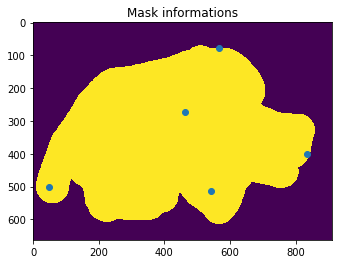

In [30]:
# load mask of this size

leman_west = (6.148131, 46.206042)
quatre_canton_north = (8.435177, 47.082150)
majeur_east = (8.856851, 46.151857)
east_end = (10.472221, 46.544303)
constance_nw = (9.035247, 47.812716)

landmarks_colors = {
    leman_west: raw_red,
    quatre_canton_north: raw_green,
    majeur_east: raw_blue,
    constance_nw: raw_pink,
    east_end: raw_yellow,
}

def coord_color(img, color):
    return np.array(list(zip(*(img == color).all(-1).nonzero())))

def open_mask(height, width):
    masks_path = '../map-masks/'
    mask_name = '{}x{}.gif'.format(height, width)
    mask_path = os.path.join(masks_path, mask_name)
    mask = Image.open(mask_path)
    mask = mask.convert('RGB')
    mask = np.array(mask)
    
    landmarks_pix = {
        geo_point: (width, height)
        for geo_point, color in landmarks_colors.items()
        for height, width in coord_color(mask, color)
    }
    
    binary_mask = (mask != 255).any(-1)  # different of white
    return binary_mask, landmarks_pix

binary_mask, landmarks_pix = open_mask(*img_arr.shape[:2])

fix, ax = plt.subplots()
ax.imshow(binary_mask);
widths, heights = list(zip(*landmarks_pix.values()))
ax.scatter(widths, heights);
ax.set_title('Mask informations');

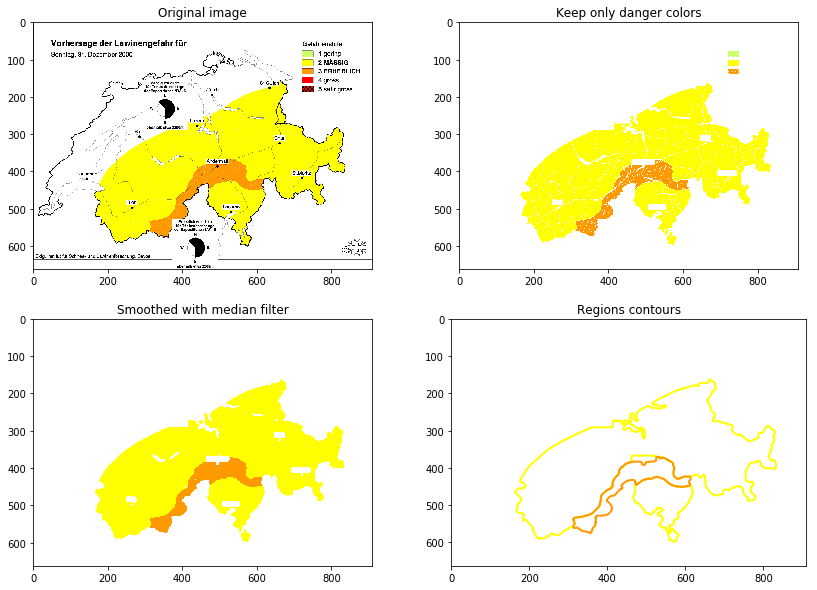

In [31]:
fig, axes = plt.subplots(2, 2, figsize=(14,10))

# original image
axes[0][0].imshow(img_arr);
axes[0][0].set_title('Original image');

# keep useful colors
regions_only = keep_colors(img_arr, [green, yellow, orange, red])
axes[0][1].imshow(regions_only);
axes[0][1].set_title('Keep only danger colors');

# clip the binary mask to remove color key
regions_only[~binary_mask] = 255
regions_only = Image.fromarray(regions_only).convert('RGB')
smoothed = regions_only.filter(ImageFilter.MedianFilter(7))
axes[1][0].imshow(smoothed);
axes[1][0].set_title('Smoothed with median filter');

# extract contours
axes[1][1].set_xlim([0, img_arr.shape[1]])
axes[1][1].set_ylim([0, img_arr.shape[0]])
axes[1][1].invert_yaxis()
axes[1][1].set_title('Regions contours')
for color in [green, yellow, orange, red]:
    contours = color_contours(smoothed, color)
    for contour in contours:
        axes[1][1].plot(contour[:, 1], contour[:, 0], linewidth=2, c=[x / 255 for x in color])


## Contours to map polygon

Once we have contours we want to transform it into geographic coordinates and simplify the polygons.

To do this transformation, we use 5 points on the map to learn a transformation matrix $T$ that maps a pixel of the image to a geolocation. We could use only 3 points to have a valid transformation, but to dicrease the error we use 5 and solve a leastquare problem.

| Location | Color |
| -------- | ----- |
| Leman W | red |
| Quatre canton N | green |
| Lac majeur E | blue |
| Lac Constance NW | pink |
| Swiss E | yellow |

In [8]:
landmarks_pix

{(6.148131, 46.206042): (51, 518),
 (8.435177, 47.08215): (480, 281),
 (8.856851, 46.151857): (563, 533),
 (9.035247, 47.812716): (587, 79),
 (10.472221, 46.544303): (866, 415)}

In [9]:
pix = np.array(list(map(numpify, landmarks_pix.values())))
coord = np.array(list(map(numpify, landmarks_pix.keys())))

# add 1 bias raw
pix_ext = np.vstack([np.ones((1,pix.shape[0])), pix.T])
coord_ext = np.vstack([np.ones((1,pix.shape[0])), coord.T])

# T = np.linalg.solve(
T = np.linalg.lstsq(pix_ext.T, coord_ext.T)[0]

def transform_pix2map(points):
    """n x 2 array"""
    points_ext = np.hstack([np.ones((points.shape[0], 1)), points])
    points_map = points_ext.dot(T)
    return points_map[:, 1:]


We smooth the polygon to remove some useless points and make thme a bit lighter.

In [10]:
import json
import visvalingamwyatt as vw

SMOOTHING_THRESHOLD = 0.0001

geo_json = {
  "type": "FeatureCollection",
  "features": []
}

for danger_level, color in enumerate([green, yellow, orange, red]):
    for contour in color_contours(smoothed, color):
        contour_right = contour.copy()
        contour_right[:,0] = contour[:,1]
        contour_right[:,1] = contour[:,0]
        contour_right = transform_pix2map(contour_right)
        simplifier = vw.Simplifier(contour_right)
        contour_right = simplifier.simplify(threshold=SMOOTHING_THRESHOLD)
        geo_json['features'].append({
            "type": "Feature",
            "properties": {
                "date": "TODO",
                "danger_level": danger_level + 1
            },
            "geometry": {
                "type": "Polygon",
                "coordinates": [ list(reversed(contour_right.tolist())) ]
            }
        })

In [11]:
import folium

switzerland = (46.875893, 8.289321)
tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Topo_Map/MapServer/tile/{z}/{y}/{x}'
attr = 'Tiles &copy; Esri &mdash; Esri, DeLorme, NAVTEQ, TomTom, Intermap, iPC, USGS, FAO, NPS, NRCAN, GeoBase, Kadaster NL, Ordnance Survey, Esri Japan, METI, Esri China (Hong Kong), and the GIS User Community'
m = folium.Map(location=switzerland, zoom_start=8, tiles=tiles, attr=attr)               

colors = ['#ccff66', '#ffff00', '#ff9900', '#ff0000']

def style_function(risk_region):
    level = risk_region['properties']['danger_level']
    color = colors[level - 1]
    return {
        'fillOpacity': .5,
        'weight': 0,
        'fillColor': color,
        'color': 'white',
    }

folium.GeoJson(
    geo_json,
    name='geojson',
    style_function=style_function
).add_to(m)

m

Use `src/map_extractor.py` script to extract in batch GeoJSON information from the gifs. Then you can visualize some of them here.

In [23]:
m = folium.Map(location=switzerland, zoom_start=8, tiles=tiles, attr=attr)               

folium.GeoJson(
    json.load(open(r'../json-maps/20001230_nbk_de_c.json')),
    name='geojson',
    style_function=style_function
).add_to(m)

m